## SQLAlchemy Homework Dependencies

In [1]:
# dependencies
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///C:/Users/leala/Documents/Data Git Repo/python-challenge/Boot Camp Homework/SQLAlchemy/Resources/hawaii.sqlite")
session = Session(engine)
inspector = inspect(engine)

In [4]:
inspector.get_table_names()

['measurement', 'station']

In [5]:
columns_m = inspector.get_columns('measurement')
for c in columns_m:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
columns_s = inspector.get_columns('station')
for c in columns_s:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [8]:
measurement = Base.classes.measurement
station = Base.classes.station

## Part 1 - Precipitation Analysis
- Design a query to retrieve the last 12 months of precipitation data and plot the results
- 'Newest' Date is 8-23-17

In [9]:
# Calculate the date 1 year ago from today, cant use this though because the data is too old...
last_year = (dt.date.today() - dt.timedelta(days=365))
             
# Perform a query to retrieve the data and precipitation scores
date = []
precip = []
for row in session.query(measurement.date, measurement.prcp).filter(measurement.date.between('2016-08-23', '2017-08-23')).all():
    date.append(row[0])
    precip.append(row[1])

# Save the query results as a Pandas DataFrame and set the index to the date column, and sort by date
precip_df = pd.DataFrame({'Date': date,
                          'Precipitation': precip
                         })
precip_df.set_index('Date').sort_values(by=['Date'], ascending=False).head(3)

,Precipitation
Date,
2017-08-23,0.45
2017-08-23,0.08
2017-08-23,0.00


<IPython.core.display.Javascript object>


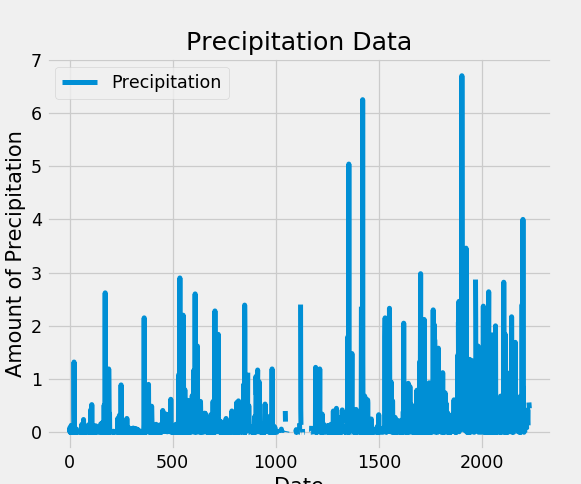

In [37]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()
plt.ylabel('Amount of Precipitation')
plt.xlabel('Date')
plt.title('Precipitation Data')
plt.show()

## Part 2 - Station Analysis
- Use Pandas to calculate the summary statistics for the precipitation data

In [11]:
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# How many stations are available in this dataset?
uni_stations = session.query(station.id).distinct().count()
print(f"There are {uni_stations} Stations in the dataset")

There are 9 Stations in the dataset


In [13]:
# What are the most active stations?  List the stations and the counts in descending order
engine.execute('SELECT m.station, count(m.id) FROM measurement m GROUP BY m.station ORDER BY 2 DESC').fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature most active station
temps = session.query(measurement.station, func.max(measurement.tobs), func.min(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print(f'For Station {temps[0][0]} the highest temp recorded was {temps[0][1]} degrees, the lowest temp recorded was {temps[0][2]} degrees, and the average temp was {round(temps[0][3])}.')

For Station USC00519281 the highest temp recorded was 85.0 degrees, the lowest temp recorded was 54.0 degrees, and the average temp was 72.


In [40]:
# Choose the station with the highest number of temperature observations.
highest_obs = session.query(measurement.station, measurement.tobs).filter(measurement.date >= '2016-08-23').filter(measurement.station == 'USC00519281').all()
obs_df = pd.DataFrame(highest_obs)
obs_df.head(3)

,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0


<IPython.core.display.Javascript object>


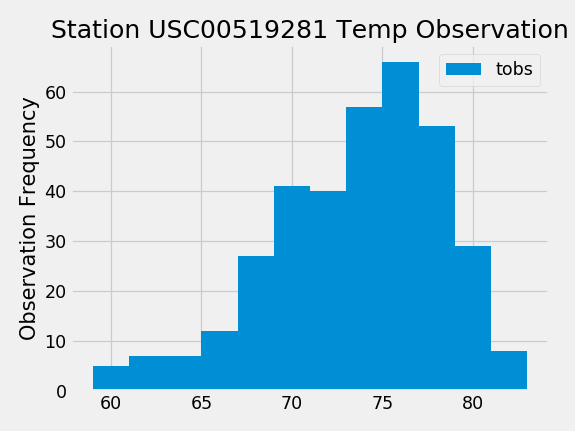

In [42]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
obs_df.plot.hist(bins=12)
plt.ylabel("Observation Frequency")
plt.title("Station USC00519281 Temp Observation")
plt.tight_layout()
plt.show()

## Part 3 - Temperature Analysis (Optional)
### To the TA grading this, I didnt finish this section so you can stop here

In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.
temp_bar = calc_temps('2016-08-23', '2017-08-23')
print(temp_bar)

[(58.0, 74.59058295964125, 87.0)]


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(temp_bar[0][1], temp_bar[0][2], align='center', alpha=0.5)
plt.ylabel('Temperature')
plt.title('Trip Average Temp')

plt.show()

In [19]:
temp_bar[0][1]

74.59058295964125

In [20]:
# Calculate the rainfall per weather station using the previous year's matching dates.  Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
joined = session.query(measurement.station, func.max(measurement.tobs), func.min(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()

session.query(Invoices.BillingPostalCode, func.sum(Items.UnitPrice * Items.Quantity)).filter(Invoices.InvoiceId == Items.InvoiceId).filter(Invoices.BillingCountry == 'USA').\
    group_by(Invoices.BillingPostalCode).\
    order_by(func.sum(Items.UnitPrice * Items.Quantity).desc()).all()

NameError: name 'Invoices' is not defined

## Part 5 - Climate App

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`